# Predict geothermal heat flux: Neural Networks

References:
* https://github.com/amirkdv/ghf-greenland-gbrt

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.compat.v1 import set_random_seed
import math
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
from sklearn import preprocessing
from tensorflow.keras import optimizers
from project import plt_ant_feat

In [2]:
# Normalized root-mean-square error
def rmse(y_test, pred):
    return (1 / np.average(y_test)) * math.sqrt(np.average((y_test - pred)**2))

Load the data.

In [3]:
data_train = pd.read_csv('data/R17_global_train.csv')
X_train = data_train.drop(['lon', 'lat', 'GHF'], axis=1)
y_train = data_train[['GHF']].values.ravel()

labels = X_train.columns.values
num_features = len(labels)

data_test = pd.read_csv('data/R17_global_test.csv')
X_test = data_test.drop(['lon', 'lat', 'GHF'], axis=1)
y_test = data_test[['GHF']].values.ravel()

# Load Antarctic features
data_ant = pd.read_csv('data/ant_features.csv')
X_ant = data_ant.drop(['lon', 'lat'], axis=1)

# Scale X
scaler = preprocessing.QuantileTransformer()
#scaler = preprocessing.MinMaxScaler()
#scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_ant = scaler.transform(X_ant)

print(labels)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('X_ant shape:', X_ant.shape)

['thickness_upper_crust' 'thickness_middle_crust'
 'upper_mantle_density_anomaly' 'd_2_ridge' 'd_2_trench' 'd_2_trans_ridge'
 'd_2_volcano' 'd_2_hotspot' 'thickness_crust' 'd_2_young_rift'
 'upper_mantle_vel_structure' 'age' 'magnetic_anomaly' 'depth_to_moho'
 'lithos_asthenos_bdry' 'bougeur_gravity_anomaly' 'topography']
X_train shape: (3227, 17)
y_train shape: (3227,)
X_test shape: (807, 17)
y_test shape: (807,)
X_ant shape: (10800, 17)


Build model

In [4]:
np.random.seed(5622)
set_random_seed(5622)

model = keras.Sequential([
    layers.Dense(512, activation='relu', kernel_initializer='normal', input_dim=X_train.shape[1]),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu', kernel_initializer='normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu', kernel_initializer='normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu', kernel_initializer='normal'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='linear', kernel_initializer='normal')
])

opt = optimizers.Adam(lr=0.0005)
#opt = optimizers.SGD(learning_rate=0.001, nesterov=True)
model.compile(loss='mse',
              optimizer=opt,
              metrics=['mae', 'mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(
    X_train, y_train,
    epochs=1000,
    #validation_split = 0.2,
    verbose=0)#, callbacks=[early_stop])

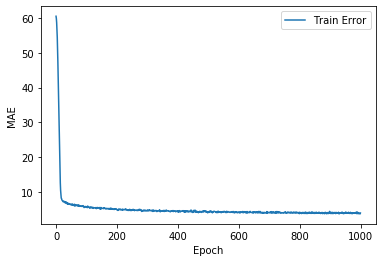

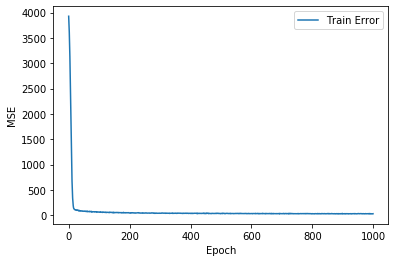

In [5]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(hist['epoch'], hist['mae'], label='Train Error')
#plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(hist['epoch'], hist['mse'], label='Train Error')
#plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
plt.legend()
plt.show()

In [6]:
print('TRAIN')
pred = model.predict(X_train).T[0]
print('Train R^2:', r2_score(y_train, pred))
print ('Train RMSE:', rmse(y_train, pred))
print ('Train MAE:', np.average(np.abs(y_train - pred)))
print()

print('TEST')
pred = model.predict(X_test).T[0]
print('Test R^2:', r2_score(y_test, pred))
print ('Test RMSE:', rmse(y_test, pred))
print ('Test MAE:', np.average(np.abs(y_test - pred)))

TRAIN
Train R^2: 0.9737198449573137
Train RMSE: 0.04801469296650235
Train MAE: 1.7894437317505638

TEST
Test R^2: 0.7417543867017113
Test RMSE: 0.15845018920977474
Test MAE: 5.751751468051069


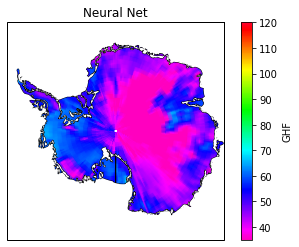

In [7]:
pred = model.predict(X_ant)
pred = pred.T[0]
plt_ant_feat(pred, title='Neural Net')